# Molecular basis of opioid receptor signaling
https://doi.org/10.1016/j.cell.2023.10.029

In [1]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [2]:
from data.converter.pdb_to_list_blocks import pdb_to_list_blocks
from data.converter.sm_pdb_to_blocks import sm_pdb_to_blocks
from data.dataset import VOCAB
from data.dataset import blocks_interface, blocks_to_data
from data.dataset import BlockGeoAffDataset
import models
import torch
from trainers.abs_trainer import Trainer
import importlib
import matplotlib.pyplot as plt

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
importlib.reload(models)
import models
import data.dataset
importlib.reload(data.dataset)
from data.dataset import blocks_interface

In [4]:
pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_71/checkpoint/epoch66_step9045.ckpt"
model = models.AffinityPredictor.load_from_pretrained(pretrain_ckpt)

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__in

In [24]:
receptor_file = "8ef5.pdb"
ligand_file = "8ef5_ligand_chM.pdb"
chain = "M"

In [25]:
raw_receptor_blocks = pdb_to_list_blocks(receptor_file, selected_chains=[chain])[0]
ligand = sm_pdb_to_blocks(ligand_file)
receptor_blocks, _, receptor_indexes, ligand_indexes = blocks_interface(raw_receptor_blocks, ligand, 8.0, return_indexes=True)
data = blocks_to_data(receptor_blocks, ligand)
data["label"] = -1

In [26]:
from Bio.PDB import PDBParser
from data.dataset import Block, Atom, VOCAB

receptor_pdb_indexes = []

pdb = receptor_file
selected_chains = [chain]

parser = PDBParser(QUIET=True)
structure = parser.get_structure('anonym', pdb)

list_blocks, chain_ids = [], {}

for chain in structure.get_chains():

    _id = chain.get_id()
    if (selected_chains is not None) and (_id not in selected_chains):
        continue

    residues, res_ids = [], {}

    for idx, residue in enumerate(chain):
        abrv = residue.get_resname()
        residx = residue.get_id()[1]
        if idx in receptor_indexes:
            receptor_pdb_indexes.append((idx, abrv, residx))
        hetero_flag, res_number, insert_code = residue.get_id()
        res_id = f'{res_number}-{insert_code}'
        if hetero_flag == 'W':
            continue   # residue from glucose (WAT) or water (HOH)
        if hetero_flag.strip() != '' and res_id in res_ids:
            continue  # the solution (e.g. H_EDO (EDO))
        if abrv == 'MSE':
            abrv = 'MET'  # MET is usually transformed to MSE for structural analysis
        symbol = VOCAB.abrv_to_symbol(abrv)
            
        # filter Hs because not all data include them
        atoms = [ Atom(atom.get_id(), atom.get_coord(), atom.element) for atom in residue if atom.element != 'H' ]
        residues.append(Block(symbol, atoms))
        res_ids[res_id] = True
    
#     # the last few residues might be non-relevant molecules in the solvent if their types are unk
#     end = len(residues) - 1
#     while end >= 0:
#         if residues[end].symbol == VOCAB.UNK:
#             end -= 1
#         else:
#             break
#     residues = residues[:end + 1]
#     if len(residues) == 0:  # not a chain
#         continue

#     chain_ids[_id] = len(list_blocks)
#     list_blocks.append(residues)

# # reorder
# if selected_chains is not None:
#     list_blocks = [list_blocks[chain_ids[chain_id]] for chain_id in selected_chains]

In [27]:
batch = BlockGeoAffDataset.collate_fn([data])
batch = Trainer.to_device(batch, "cuda:0")
model = model.to("cuda:0")
res = model.infer(batch, return_block_energy=True)
print("Prediction:", res[0])
print("Block level prediction:", res[1])

Prediction: tensor([6.7745], device='cuda:0', grad_fn=<NegBackward0>)
Block level prediction: tensor([ 0.1350,  0.0846,  0.0379,  0.0259,  0.0950, -0.0139,  0.0129,  0.0114,
        -0.0219,  0.0629,  0.1033,  0.0351,  0.0465,  0.1615,  0.1503,  0.0372,
         0.1582,  0.0697,  0.0410,  0.0246,  0.0238,  0.0565,  0.1355,  0.0386,
         0.1259,  0.1479,  0.1124,  0.0027,  0.0354,  0.1227, -0.0005,  0.1530,
         0.0564,  0.0711,  0.1544,  0.1556,  0.0222,  0.0494,  0.2112,  0.1593,
         0.1486,  0.1260,  0.1401,  0.1659,  0.1648,  0.1616,  0.1609,  0.1620,
         0.1518,  0.1425,  0.1686,  0.1682,  0.1606,  0.1673,  0.1504,  0.1327,
         0.1112,  0.1444,  0.1420,  0.1582,  0.1618,  0.1691,  0.1638,  0.1617],
       device='cuda:0', grad_fn=<NegBackward0>)


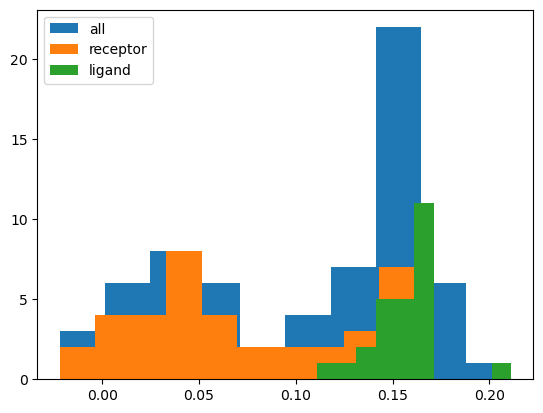

In [28]:
plt.hist(res[1].cpu().detach().numpy(), label="all")
plt.hist(res[1][batch["segment_ids"] == 0].cpu().detach().numpy(), label="receptor")
plt.hist(res[1][batch["segment_ids"] == 1].cpu().detach().numpy(), label="ligand")
plt.legend()
plt.show()

In [29]:
res_sorted, res_indexes = torch.sort(res[1], descending=True)
res_indexes

tensor([38, 61, 50, 51, 53, 43, 44, 62, 47, 60, 63, 45, 13, 46, 52, 39, 16, 59,
        35, 34, 31, 48, 54, 14, 40, 25, 57, 49, 58, 42, 22,  0, 55, 41, 24, 29,
        26, 56, 10,  4,  1, 33, 17,  9, 21, 32, 37, 12, 18, 23,  2, 15, 28, 11,
         3, 19, 20, 36,  6,  7, 27, 30,  5,  8], device='cuda:0')

In [30]:
res_sorted

tensor([ 0.2112,  0.1691,  0.1686,  0.1682,  0.1673,  0.1659,  0.1648,  0.1638,
         0.1620,  0.1618,  0.1617,  0.1616,  0.1615,  0.1609,  0.1606,  0.1593,
         0.1582,  0.1582,  0.1556,  0.1544,  0.1530,  0.1518,  0.1504,  0.1503,
         0.1486,  0.1479,  0.1444,  0.1425,  0.1420,  0.1401,  0.1355,  0.1350,
         0.1327,  0.1260,  0.1259,  0.1227,  0.1124,  0.1112,  0.1033,  0.0950,
         0.0846,  0.0711,  0.0697,  0.0629,  0.0565,  0.0564,  0.0494,  0.0465,
         0.0410,  0.0386,  0.0379,  0.0372,  0.0354,  0.0351,  0.0259,  0.0246,
         0.0238,  0.0222,  0.0129,  0.0114,  0.0027, -0.0005, -0.0139, -0.0219],
       device='cuda:0', grad_fn=<SortBackward0>)

In [32]:
receptor_res_indexes = res_indexes[batch["segment_ids"][res_indexes] == 0]
receptor_res_indexes

tensor([13, 16, 35, 34, 31, 14, 25, 22,  0, 24, 29, 26, 10,  4,  1, 33, 17,  9,
        21, 32, 37, 12, 18, 23,  2, 15, 28, 11,  3, 19, 20, 36,  6,  7, 27, 30,
         5,  8], device='cuda:0')

### Highest contributing amino acids in receptor to binding affinity

In [33]:
print("Total receptor amino acids =", len(receptor_res_indexes))
for i in receptor_res_indexes.cpu().detach()[:10]:
    if i == 0:
        print("global node")
    print(receptor_pdb_indexes[i-1])

Total receptor amino acids = 38
(83, 'ASP', 149)
(87, 'MET', 153)
(262, 'TYR', 328)
(261, 'GLY', 327)
(258, 'ILE', 324)
(84, 'TYR', 150)
(232, 'ILE', 298)
(172, 'VAL', 238)
global node
(265, 'SER', 331)
(229, 'TRP', 295)


In [20]:
segment_ids, lengths, block_lengths, A = batch["segment_ids"], batch["lengths"], batch["block_lengths"], batch["A"]
batch_id = torch.zeros_like(segment_ids)  # [Nb]
batch_id[torch.cumsum(lengths, dim=0)[:-1]] = 1
batch_id = batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch

block_id = torch.zeros_like(A) # [Nu]
block_id[torch.cumsum(block_lengths, dim=0)[:-1]] = 1
block_id = block_id.cumsum_(dim=0)  # [Nu], block (residue) id of each unit (atom)

# Binding affinity predictions
The binding affinity of the ligands (higher binding affinity value $pK_d$ = more potent) to the receptors match the published order of potency: morphine < fentanyl < lofentanil
* Lofentanil
    * 7t2h: 7.4444
* Fentanyl
    * 8ef5_chR: 6.7673
    * 8ef5_chM: 6.7745
* Morphine
    * 8ef6_chM: 5.9950
    * 8ef6_chR: 5.9950

# Analysing 8ef5_chM-fentanyl interactions
Ordering the amino acids by their energy from highest to lowest shows which amino acids contribute the most to the binding affinity of fentanyl to the mu-opioid receptor. The top amino acids are:
* (1) ASP 149, chain M: it looks like the NH2 on asparagine interacts with the N in the fentanyl in the form of hydrogen bonding. This matches what is published here "in which the charged piperidine amine of fentanyl forms a salt bridge with Asp147 (note the two pdb files use diff numberings)" https://www.nature.com/articles/s41467-021-21262-9
* (2) MET 153, chain M: the sulfur interacts with the benzene - a favourable, stabilising methionine-aromatic interaction https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3471747/ 
* (3) TYR 328, chain M: **also identified in Cell review** - that fentanyl’s benzene ring engages in direct pi-pi interactions with the toggle switch residues W295 and Y328
* (10) **also identified in Cell review** W295 ranks 10th out of the 38 amino acids in the pocket


Questions to answer: how strongly does this correlate with minimum distance?

TODO: openeye visualisation of the binding pocket